# Tune and Train with Kubeflow Katib and Training Operator
 
In this Notebook we are going to do the following:

- Train Tensorflow model using Kubeflow Notebook.
- Improve the model HyperParameters with [Kubeflow Katib](https://www.kubeflow.org/docs/components/katib/overview/).
- Use [Multi Worker Mirrored Strategy](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/MultiWorkerMirroredStrategy) to distributively train the model with [Kubeflow TFJob](https://www.kubeflow.org/docs/components/training/tftraining/).

## Install Kubeflow Python SDKs

You need to install Tensorflow package and Kubeflow SDKs to run this Notebook.

In [ ]:
!pip install tensorflow==2.9.1

# TODO (andreyvelich): Change to release version when SDK with the new APIs is published.
!pip install git+https://github.com/kubeflow/katib.git#subdirectory=sdk/python/v1beta1
!pip install git+https://github.com/kubeflow/training-operator.git#subdirectory=sdk/python

## Create Train Script for CNN Model

This is simple **Convolutional Neural Network (CNN)** model for recognizing hand-written digits using [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).  

In [1]:
def train_mnist_model(parameters):
    import tensorflow as tf
    import numpy as np
    import logging

    logging.basicConfig(
        format="%(asctime)s %(levelname)-8s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%SZ",
        level=logging.INFO,
    )
    logging.info("--------------------------------------------------------------------------------------")
    logging.info(f"Input Parameters: {parameters}")
    logging.info("--------------------------------------------------------------------------------------\n\n")


    # Get HyperParameters from the input params dict.
    lr = float(parameters["lr"])
    num_epoch = int(parameters["num_epoch"])

    # Set dist parameters and strategy.
    is_dist = parameters["is_dist"]
    num_workers = parameters["num_workers"]
    batch_size_per_worker = 64
    batch_size_global = batch_size_per_worker * num_workers
    strategy = tf.distribute.MultiWorkerMirroredStrategy(
        communication_options=tf.distribute.experimental.CommunicationOptions(
            implementation=tf.distribute.experimental.CollectiveCommunication.RING
        )
    )

    # Callback class for logging training.
    # Katib parses metrics in this format: <metric-name>=<metric-value>.
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            logging.info(
                "Epoch {}/{}. accuracy={:.4f} - loss={:.4f}".format(
                    epoch+1, num_epoch, logs["accuracy"], logs["loss"]
                )
            )

    # Prepare MNIST Dataset.
    def mnist_dataset(batch_size):
        (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
        x_train = x_train / np.float32(255)
        y_train = y_train.astype(np.int64)
        train_dataset = (
            tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(60000)
            .repeat()
            .batch(batch_size)
        )
        return train_dataset

    # Build and compile CNN Model.
    def build_and_compile_cnn_model():
        model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28)),
                tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(32, 3, activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(10),
            ]
        )
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
            metrics=["accuracy"],
        )
        return model
    
    # Download Dataset.
    dataset = mnist_dataset(batch_size_global)

    # For dist strategy we should build model under scope().
    if is_dist:
        logging.info("Running Distributed Training")
        logging.info("--------------------------------------------------------------------------------------\n\n")
        with strategy.scope():
            model = build_and_compile_cnn_model()
    else:
        logging.info("Running Single Worker Training")
        logging.info("--------------------------------------------------------------------------------------\n\n")
        model = build_and_compile_cnn_model()
    
    # Start Training.
    model.fit(
        dataset,
        epochs=num_epoch,
        steps_per_epoch=70,
        callbacks=[CustomCallback()],
        verbose=0,
    )

## Run Training Locally in the Notebook

We are going to download MNIST Dataset and start local training.

Also, set `Epochs = 2` to reduce training time and avoid CPU overload. 

In [2]:
# Set Parameters for Local Training.
parameters = {
    "lr": "0.1",
    "num_epoch": "2",
    "is_dist": False,
    "num_workers": 1
}

# Train Model locally in the Notebook.
train_mnist_model(parameters)

2022-09-12T18:47:45Z INFO     --------------------------------------------------------------------------------------
2022-09-12T18:47:45Z INFO     Input Parameters: {'lr': '0.1', 'num_epoch': '2', 'is_dist': False, 'num_workers': 1}
2022-09-12T18:47:45Z INFO     --------------------------------------------------------------------------------------


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.RING


2022-09-12T18:47:45Z INFO     Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.RING


11490434/11490434 [==============================] - 1s 0us/step


2022-09-12T18:47:51Z INFO     Running Single Worker Training
2022-09-12T18:47:51Z INFO     --------------------------------------------------------------------------------------


2022-09-12T18:49:24Z INFO     Epoch 1/2. accuracy=0.7310 - loss=0.8630
2022-09-12T18:50:45Z INFO     Epoch 2/2. accuracy=0.8862 - loss=0.3731


## Start Model Tuning with Katib

If you want to improve your model, you can run HyperParameter tuning with Katib.

The following example uses **Covariance Matrix Adaptation Evolution Strategy (CMA-ES)** algorithm to tune HyperParameters.

We are going to tune `learning rate` and `number of epochs`.

In [13]:
import kubeflow.katib as katib

# Set parameters with their distribution for HyperParameter Tuning with Katib.
parameters = {
    "lr": katib.search.double(min=0.1, max=0.2),
    "num_epoch": katib.search.int(min=10, max=15),
    "is_dist": False,
    "num_workers": 1
}

# Start the Katib Experiment.
exp_name = "tune-mnist"
katib_client = katib.KatibClient()

katib_client.tune(
    name=exp_name,
    objective=train_mnist_model, # Objective function.
    parameters=parameters, # HyperParameters to tune.
    algorithm_name="cmaes", # Alorithm to use.
    objective_metric_name="accuracy", # Katib is going to optimize "accuracy".
    additional_metric_names=["loss"], # Katib is going to collect these metrics in addition to the objective metric.
    max_trial_count=12, # Trial Threshold.
    parallel_trial_count=2,
)

Experiment tune-mnist has been created


### Access to Katib UI

You can check created Experiment in the Katib UI.

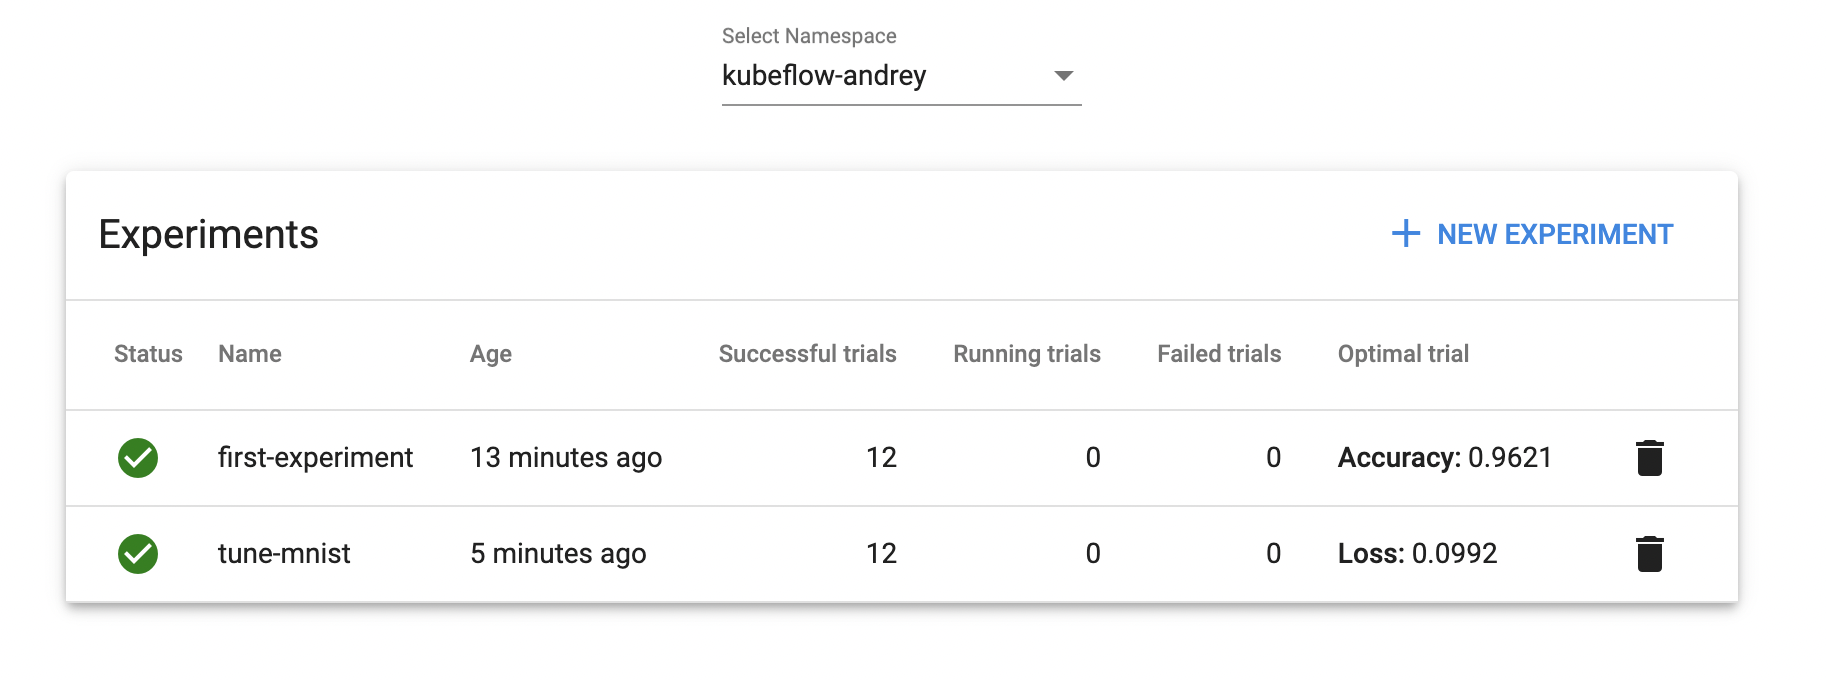

### Get the Best HyperParameters from the Katib Experiment

You can get the best HyperParameters from the most optimal Katib Trial.

In [14]:
status = katib_client.is_experiment_succeeded(exp_name)
print(f"Katib Experiment is Succeeded: {status}\n")

best_hps = katib_client.get_optimal_hyperparameters(exp_name)

if best_hps != None:
    print("Current Optimal Trial\n")
    print(best_hps)
    
    for hp in best_hps.parameter_assignments:
        if hp.name == "lr":
            best_lr = hp.value
        else:
            best_num_epoch = hp.value

Katib Experiment is Succeeded: True

Current Optimal Trial

{'best_trial_name': 'tune-mnist-l8xvxzvj',
 'observation': {'metrics': [{'latest': '0.9694',
                              'max': '0.9694',
                              'min': '0.7203',
                              'name': 'accuracy'},
                             {'latest': '0.1007',
                              'max': '0.9082',
                              'min': '0.1007',
                              'name': 'loss'}]},
 'parameter_assignments': [{'name': 'num_epoch', 'value': '13'},
                           {'name': 'lr', 'value': '0.16377224201308005'}]}


## Start Distributive Training with TFJob

Use the best HyperParameters (`learning rate` and `number of epochs`) from the Katib Experiment and run the TFJob.

In [15]:
from kubeflow.training import TFJobClient

# Set Parameters for Distributed Training with TFJob.
parameters = {
    "lr": best_lr,
    "num_epoch": best_num_epoch,
    "is_dist": True,
    "num_workers": 5
}

# Start TFJob Training.
tfjob_name = "train-mnist"
tfjob_client = TFJobClient()

tfjob_client.create_tfjob_from_func(
    name=tfjob_name,
    func=train_mnist_model,
    parameters=parameters, # Input parameters for the train function.
    num_worker_replicas=5, # How many TFJob Workers will be run.
)

2022-09-12T19:08:51Z INFO     TFJob train-mnist has been created


### Get TFJob Status and Training Logs

You can check the TFJob status and logs.

In [16]:
print(f"TFJob status: {tfjob_client.get_job_status(tfjob_name)}")

TFJob status: Succeeded


In [17]:
tfjob_client.get_logs(name=tfjob_name, master=True, follow=True)

2022-09-12T19:10:11Z INFO     [Pod train-mnist-worker-0]: 2022-09-12T19:08:53Z INFO     --------------------------------------------------------------------------------------
2022-09-12T19:10:11Z INFO     [Pod train-mnist-worker-0]: 2022-09-12T19:08:53Z INFO     Input Parameters: {'lr': '0.17016692449867332', 'num_epoch': '13', 'is_dist': True, 'num_workers': 5}
2022-09-12T19:10:11Z INFO     [Pod train-mnist-worker-0]: 2022-09-12T19:08:53Z INFO     --------------------------------------------------------------------------------------
2022-09-12T19:10:12Z INFO     [Pod train-mnist-worker-0]: 2022-09-12 19:08:53.988515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
2022-09-12T19:10:12Z INFO     [Pod train-mnist-worker-0]: To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

## Delete Katib Experiment and TFJob

When jobs are finished, you can delete the resources.

In [18]:
katib_client.delete_experiment(exp_name)

Experiment tune-mnist has been deleted


In [19]:
tfjob_client.delete(tfjob_name)

2022-09-12T19:10:19Z INFO     TFJob train-mnist has been deleted
